In [1]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import numpy as np
from scipy.interpolate import interp1d

## data load & preprocessing

In [2]:
myConf = pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf = myConf)\
        .getOrCreate()

21/12/15 13:52:24 WARN Utils: Your hostname, jeongxoo.local resolves to a loopback address: 127.0.0.1; using 172.20.10.4 instead (on interface en0)
21/12/15 13:52:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/15 13:52:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## step data

In [3]:
step_df = pd.read_excel(os.path.join("data", "steps.xlsx"), names=["data"])

In [4]:
step_list = list(step_df["data"])

In [5]:
temp = []
step_temp = []
for i in range(len(step_list)):
    temp.append(step_list[i])
    if i % 2 != 0:
        step_temp.append(temp)
        temp = []

In [6]:
stepRDD = spark.sparkContext.parallelize(step_temp)

In [7]:
changeStep = stepRDD.map(lambda x: (x[0].split(), x[1]))\
                    .map(lambda x: ("2021-11-18 " + x[0][2], x[1]))\
                    .map(lambda x: (x[0].replace(" ", " 0"), x[1]) if len(x[0]) == 15 else (x[0], x[1]))\
                    .sortByKey(lambda x: x[0])

In [8]:
time_stamp_step = changeStep.map(lambda x: x[0][-5:]).collect()
step_count = changeStep.map(lambda x: x[1]).collect()

/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


## separate

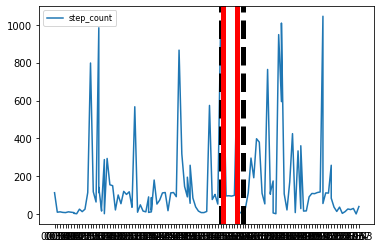

In [9]:
plt.plot(time_stamp_step, step_count, label = "step_count")
plt.rcParams['figure.figsize'] = (50, 5)
plt.rcParams['font.size'] = 8
plt.axvline(60, color='black', linestyle='--', linewidth=5) # 14:57 pm -> 1차 대기실 / 2차 대기실 / 면접 장소 이동
plt.axvline(61, color='red', linestyle='solid', linewidth=5) # 15:01 pm -> 면접 시작
plt.axvline(66, color='red', linestyle='solid', linewidth=5) # 15:41 pm -> 면접 종료
plt.axvline(68, color='black', linestyle='--', linewidth=5) # 15:43 pm -> 종료 후 대기실
plt.legend()

## heart rate data

In [10]:
heart_df = pd.read_excel(os.path.join("data", "hearts.xlsx"), names=["data"])

In [11]:
heart_list = list(heart_df["data"])

In [12]:
heart_df

,data
0,Oct 18 23:57 >
1,74
2,Oct 18 23:50 >
3,82
4,Oct 18 23:45 >
...,...
1552,Oct 18 00:09 >
1553,74
1554,Oct 18 00:05 >
1555,73


In [13]:
temp = []
heart_temp = []
for i in range(len(heart_list)):
    temp.append(heart_list[i])
    if i % 2 != 0:
        heart_temp.append(temp)
        temp = []

In [14]:
heartRDD = spark.sparkContext.parallelize(heart_temp)

In [15]:
changeHeart = heartRDD.map(lambda x: (x[0].split(), x[1]))\
                    .map(lambda x: ("2021-11-18 " + x[0][2], x[1]))\
                    .map(lambda x: (x[0].replace(" ", " 0"), x[1]) if len(x[0]) == 15 else (x[0], x[1]))\
                    .sortByKey(lambda x: x[0])\
                    .combineByKey(lambda value: (value, 1),
                                  lambda x,value: (x[0] + value, x[1] + 1),
                                  lambda x,y: (x[0] + y[0], x[1] + y[1]))\
                    .map(lambda x: (x[0], x[1][0]/x[1][1]))

## plot heart rate

In [17]:
time_stamp = changeHeart.map(lambda x: x[0][-5:]).collect()
heart_rate = changeHeart.map(lambda x: x[1]).collect()

## all day long

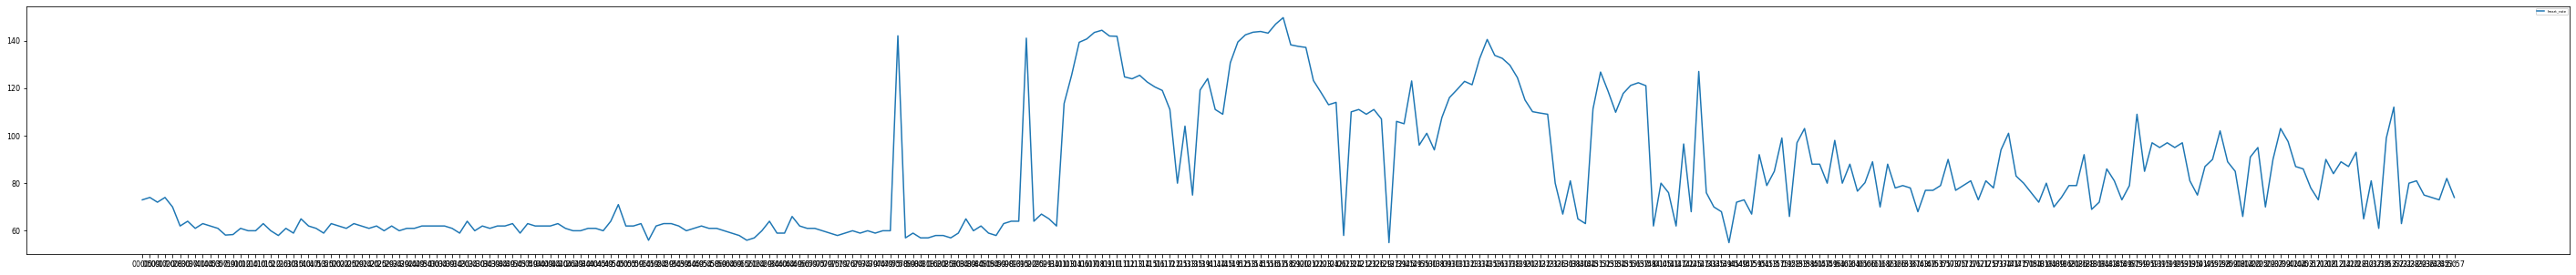

In [18]:
plt.plot(time_stamp, heart_rate, label = "heart_rate")
plt.rcParams['figure.figsize'] = (40, 5)
plt.rcParams['font.size'] = 4
plt.legend()

## 14:00 pm ~ 16:00 pm

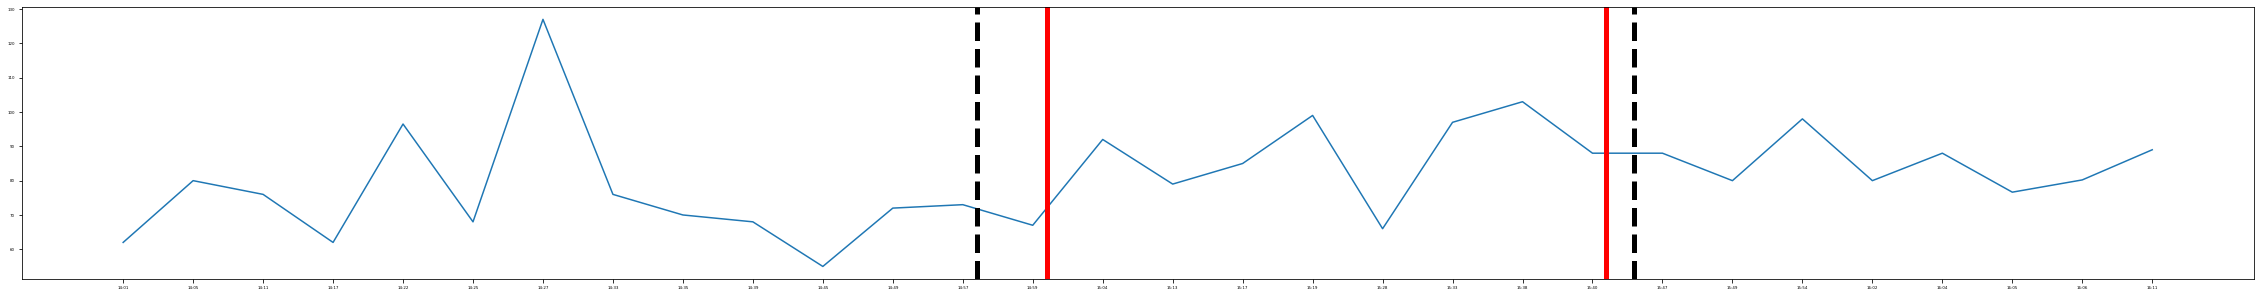

In [19]:
plt.plot(time_stamp[200:230], heart_rate[200:230], label = "heart_rate")
plt.rcParams['figure.figsize'] = (30, 5)
plt.rcParams['font.size'] = 10
plt.axvline(12.2, color='black', linestyle='--', linewidth=5) # 14:57 pm -> 1차 대기실 / 2차 대기실 / 면접 장소 이동
plt.axvline(13.2, color='red', linestyle='solid', linewidth=5) # 15:01 pm -> 면접 시작
plt.axvline(21.2, color='red', linestyle='solid', linewidth=5) # 15:41 pm -> 면접 종료
plt.axvline(21.6, color='black', linestyle='--', linewidth=5) # 15:43 pm -> 종료 후 대기실
plt.show()

## 심박 분석 방법
- 심박과 긴장 사이 관계를 파악할 때
- 단순한 심박수의 높고 낮음뿐만 아니라
- "심박변이도"라 불리는 수치를 사용
- http://www.samsunghospital.com/home/healthInfo/content/contenView.do?CONT_SRC_ID=1607&CONT_SRC=HOMEPAGE&CONT_ID=4845&CONT_CLS_CD=001004
- 이는 심박과 심박 사이의 변화량을 파악하는 것으로
- 피크가 뛴 시점 사이의 시간이 얼마나 변화하는지 보는것
- 일종의 심박 주기의 변화량으로 이해하면되는데
- 이 값이 클수록 -> 심박변이가 불규칙할수록 건강하다고 한다
- 그만큼 심장이 다양한 상황에 알맞게 운동한다는 의미라고하는데
- 이분야는 전문 분야가 아니기 때문에 이정도로 이해했다!

## 그럼 어떤 방법을?
- 아이폰에서 측정된 심박변이도 수치가 존재하긴 하지만
- 지극히 제한적인 시간대만 기록되어있음
- 심박수 또한 매 순간이 기록된 것이 아니기 때문에
- 심박변이도를 사용하는 것은 불가능
- 단순히 심박수를 기반으로 스트레스, 긴장 정도를 파악해보는 것으로 결정

### 심박변이도와 스트레스간의 연관성 증빙
- 전기환, 오주영, 박순희, 정연만, 양동일. (2010). 뇌전도와 심박변이를 이용한 감성 분석 알고리즘에 대한 연구. 한국컴퓨터정보학회논문지 , 15(10), 105-112.
- 최락현, 이동하, 강원석, 손창식. (2015). 휴대용 스트레스 측정기를 활용한 심박수 분석. 한국통신학회 학술대회논문집, (), 527-528.
- 한대석, 정나라, 김동우, 김영언, 이창호. (2007). 심박변이도 측정에 의한 한국인의 스트레스 상태 분석. 스트레스연구, 15(3), 163-169.

### 심박수와 스트레스간의 상관 관계 증빙
- 박진한, 안덕배, 백호종.(2017).심장박동수 측정을 통한 항공교통 관제사의 피로와 스트레스.한국항행학회논문지,21(1),90-98.

# 두 데이터 사이 결측치 존재
- 이는 선형보간법을 써서 처리 할 예정

In [20]:
heart_data = changeHeart.collect()
step_data = changeStep.collect()

In [21]:
step_data = dict(step_data)
heart_data = dict(heart_data)

## 데이터 첫 값 끝 값 추가 & 정렬 (선형보간 전 데이터 다듬기)

In [22]:
step_data["2021-11-18 00:00"] = 30
step_data["2021-11-18 23:59"] = 10

heart_data["2021-11-18 00:00"] = 65.0
heart_data["2021-11-18 23:59"] = 60.0

In [23]:
step_data = sorted(step_data.items(), key = lambda x: x[0])
heart_data = sorted(heart_data.items(), key = lambda x: x[0])

## 👇👇👇👇 XXX 전체 시간 생성 -> interval 1 min -> 사용할 필요가 없어짐 XXX 👇👇👇👇

In [24]:
def tryCatchStep(x):
    try:
        step_data[x]
        return (x, step_data[x])
    except:
        return (x,)

def tryCatchHeart(x):
    try:
        heart_data[x]
        return (x, heart_data[x])
    except:
        return (x,)

In [25]:
start_time = datetime(2021, 11, 18, 0, 0)
end_time = datetime(2021, 11, 18, 23, 59)
one_sec = timedelta(minutes = 1)

all_day = []

while start_time <= end_time:
    all_day.append(start_time.strftime("%Y-%m-%d %H:%M:%S"))
    start_time += one_sec

dayRDD = spark.sparkContext.parallelize(all_day)

step_no_nan = dayRDD.map(lambda x: x[:-3])\
                    .map(lambda x: tryCatchStep(x))

_step = step_no_nan.collect()

heart_no_nan = dayRDD.map(lambda x: x[:-3])\
                    .map(lambda x: tryCatchHeart(x))

_heart = heart_no_nan.collect()

## ☝🏼☝🏼☝🏼☝🏼 XXX 시간, 값 쌍으로 구성된 RDD 생성 / 필요 없어짐 XXX ☝🏼☝🏼☝🏼☝🏼

# 선형보간법 함수 구현
- 시간 순으로 정렬된 배열에 대해 사용 가능
- isitRight() -> 배열 전체에 대해 중간 값을 생성해주고 return
- yesItIsRight() -> 전체 배열이 24시간(1440분) 1440의 길이를 가질때 까지 isitRight() 반복 실행

```
함수 추가 설명
a = [(1, 3), (5, 8), (10, 15)]
-> 1 ~ 10까지 모든 값을 가진 배열 a를 생성하는 것이 목적 (선형보간법 사용)

a >> [isitRight()] >> [(1, 3), (3, 5.5) (5, 8), (7, 11.5), (10, 15)]
-> isitRight() 함수를 한번 거쳐가면 배열의 각 원소 사이의 중간 값을 가지는 원소 생성

a >> [yesItIsRight()] >> [(1, 3), (2, 4.25), (3, 5.5), (4, 6.75), (5, 8), 
                          (6, 9.75), (7, 11.5), (8, 13.25), (9, 14.125) (10, 15)]
-> yesItIsRight() 함수는 원시 배열 a의 첫값과 끝값 (1과 10) 사이의 모든 정수 값이 채워질때까지 선형보간법 시행

```

In [26]:
def isitRight(step_data):
    step_data = sorted(step_data)
    for i in range(len(step_data) - 1):
        now = datetime.strptime(step_data[i][0], "%Y-%m-%d %H:%M")
        nxt = datetime.strptime(step_data[i+1][0], "%Y-%m-%d %H:%M")

        now_value = step_data[i][1]
        nxt_value = step_data[i+1][1]

        new_t = (nxt - now) / 2
        # nn분 30초 나오는 애들은 30초를 버리고
        # nn분만 살려서 가는 형태로 갑시다
        if new_t < timedelta(minutes = 1):
            continue
        else:
            if new_t % timedelta(seconds = 60) != timedelta(seconds = 0):
                new_t -= timedelta(seconds = 30)

            new_value = (now_value + nxt_value) / 2
            new_t = now + new_t
            
            new_t.strftime("%Y-%m-%d %H:%M")
            new_t = str(new_t)
            new_t = new_t[:-3]
            step_data.append((new_t, new_value))
            
    return step_data

In [27]:
def yesItIsRight(data):
    while len(data) < 1440:
        data = isitRight(data)
    return data

In [28]:
heart_data = yesItIsRight(heart_data)
step_data = yesItIsRight(step_data)

In [29]:
step_data = sorted(step_data, key = lambda x: x[0])
heart_data = sorted(heart_data, key = lambda x: x[0])

### 시계열 그래프를 위한 x,y 값 분리

In [30]:
_x_step = spark.sparkContext.parallelize(step_data).map(lambda x: x[0]).collect()
_y_step = spark.sparkContext.parallelize(step_data).map(lambda x: x[1]).collect()

In [31]:
_x = spark.sparkContext.parallelize(heart_data).map(lambda x: x[0]).collect()
_y = spark.sparkContext.parallelize(heart_data).map(lambda x: x[1]).collect()

## 심박수 시각화 (선형보간 후)

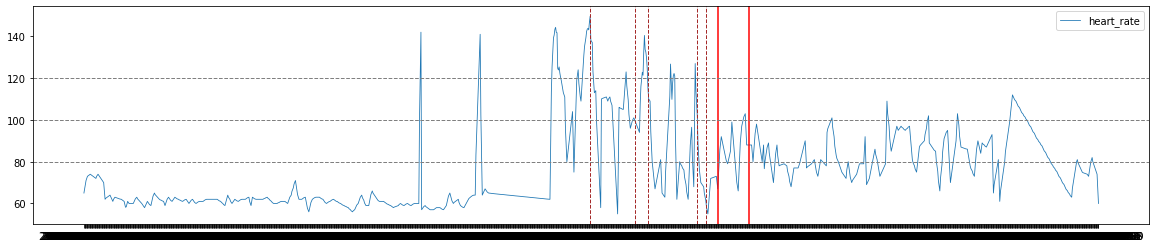

In [35]:
plt.plot(_x[:], _y[:], label = "heart_rate")
plt.rcParams['figure.figsize'] = (20, 4)
plt.rcParams['font.size'] = 10
plt.rcParams["lines.linewidth"] = 0.8

# plt.axvline(705, color = 'black', linestyle = '--', linewidth = 1) # 11:45 pm 출발

plt.axvline(718, color = 'brown', linestyle = '--', linewidth = 1) # 11:58 pm 지하철 탑승
plt.axvline(782, color = 'brown', linestyle = '--', linewidth = 1) # 13:02 pm 지하철 하차

plt.axvline(800, color = 'brown', linestyle = '--', linewidth = 1) # 13:20 pm 카페 도착
plt.axvline(870, color = 'brown', linestyle = '--', linewidth = 1) # 14:30 pm 카페 출발

plt.axvline(882, color = 'brown', linestyle = '--', linewidth = 1) # 14:42 pm 대기실 도착


plt.axvline(900, color = 'red', linestyle = 'solid', linewidth = 1.5) # 15:00 pm 면접 시작
plt.axvline(943, color = 'red', linestyle = 'solid', linewidth = 1.5) # 15:43 pm 면접 종료

plt.axhline(80, color = 'gray', linestyle = '--', linewidth = 1)
# plt.axhline(90, color = 'gray', linestyle = '--', linewidth = 1)
plt.axhline(100, color = 'gray', linestyle = '--', linewidth = 1)
# plt.axhline(110, color = 'gray', linestyle = '--', linewidth = 1)
plt.axhline(120, color = 'gray', linestyle = '--', linewidth = 1)

plt.legend()

## 걸음수 시각화 (선형보간 후)

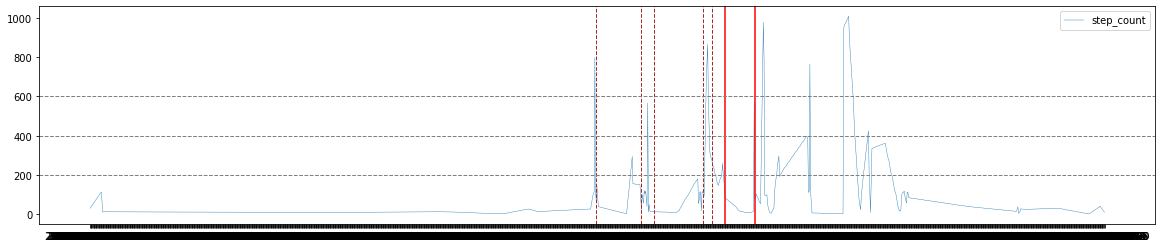

In [34]:
plt.plot(_x_step[:], _y_step[:], label = "step_count")
plt.rcParams['figure.figsize'] = (20, 4)
plt.rcParams['font.size'] = 10
plt.rcParams["lines.linewidth"] = 0.8

# plt.axvline(705, color = 'black', linestyle = '--', linewidth = 1) # 11:45 pm 출발

plt.axvline(718, color = 'brown', linestyle = '--', linewidth = 1) # 11:58 pm 지하철 탑승
plt.axvline(782, color = 'brown', linestyle = '--', linewidth = 1) # 13:02 pm 지하철 하차

plt.axvline(800, color = 'brown', linestyle = '--', linewidth = 1) # 13:20 pm 카페 도착
plt.axvline(870, color = 'brown', linestyle = '--', linewidth = 1) # 14:30 pm 카페 출발

plt.axvline(882, color = 'brown', linestyle = '--', linewidth = 1) # 14:42 pm 대기실 도착


plt.axvline(900, color = 'red', linestyle = 'solid', linewidth = 1.5) # 15:00 pm 면접 시작
plt.axvline(943, color = 'red', linestyle = 'solid', linewidth = 1.5) # 15:43 pm 면접 종료

# plt.axhline(100, color = 'gray', linestyle = '--', linewidth = 1)
plt.axhline(200, color = 'gray', linestyle = '--', linewidth = 1)
plt.axhline(400, color = 'gray', linestyle = '--', linewidth = 1)
plt.axhline(600, color = 'gray', linestyle = '--', linewidth = 1)

plt.legend()

## 보간 이후 vs 보간 이전 비교
- 면접 시간

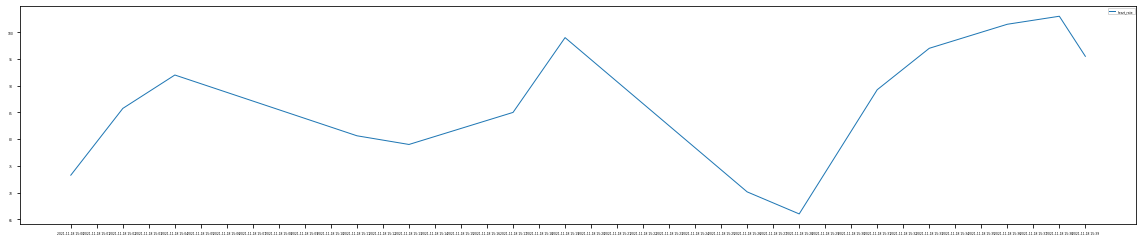

In [64]:
plt.plot(_x[900:940], _y[900:940], label = "heart_rate")
plt.rcParams['figure.figsize'] = (20, 4)
plt.rcParams['font.size'] = 3
plt.rcParams["lines.linewidth"] = 1
plt.legend()

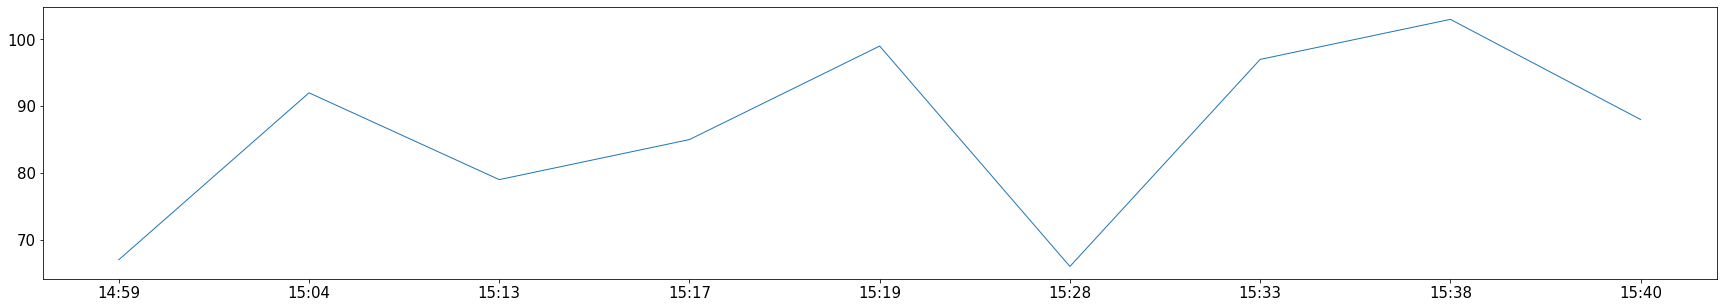

In [66]:
plt.plot(time_stamp[213:222], heart_rate[213:222], label = "heart_rate")
plt.rcParams['figure.figsize'] = (30, 5)
plt.rcParams['font.size'] = 20
plt.show()

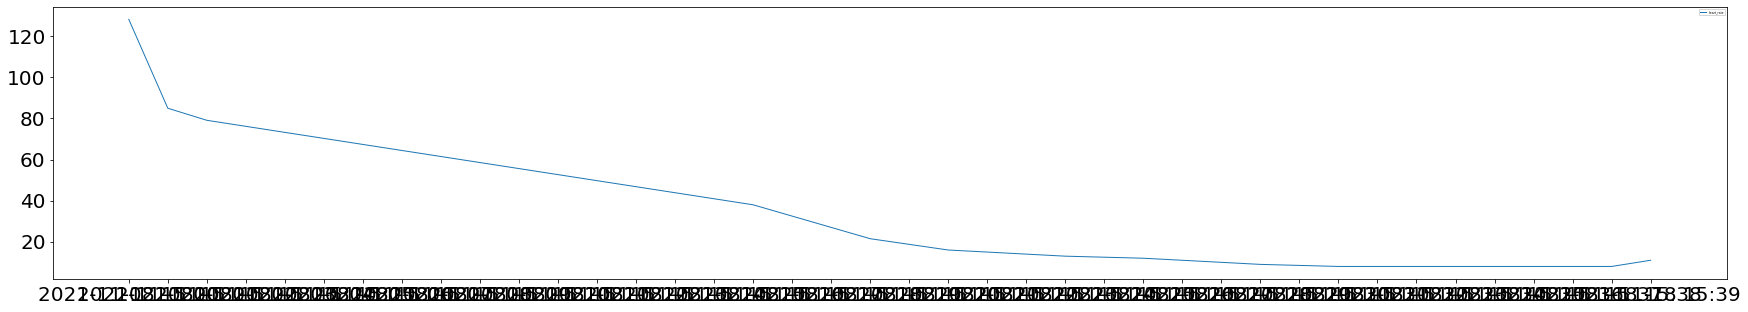

In [67]:
plt.plot(_x_step[900:940], _y_step[900:940], label = "heart_rate")
plt.rcParams['figure.figsize'] = (20, 4)
plt.rcParams['font.size'] = 3
plt.rcParams["lines.linewidth"] = 1
plt.legend()

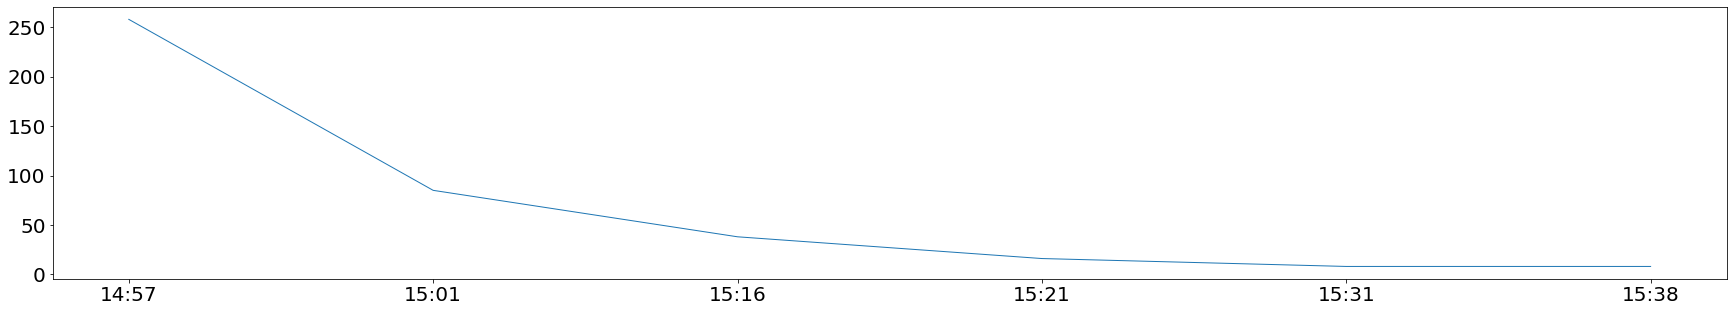

In [80]:
plt.plot(time_stamp_step[60:66], step_count[60:66], label = "heart_rate")
plt.rcParams['figure.figsize'] = (30, 5)
plt.rcParams['font.size'] = 20
plt.show()

## 추후 데이터 로드를 위해 csv 파일 형태로 데이터 저장

## 데이터에 조금 문제가 잇는듯 정렬 해봐야할 필요 잇음
- 해결 완료

In [64]:
hearts_df = pd.DataFrame(heart_data)
steps_df = pd.DataFrame(step_data)

In [65]:
hearts_df.to_csv(os.path.join("data", "heart_rate_all_day.csv"))
steps_df.to_csv(os.path.join("data", "step_count_all_day.csv"))